Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.


In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [156]:

# Carpeta de imágenes
#val_imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/images'
val_imgs_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/img'

# Carpeta de anotaciones
#val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/annotations'
val_annotations_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/ann'
images_val = [cv.imread(file) for file in list_images(val_imgs_path)]           #imágenes de validación
ann_val = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in list_images(val_annotations_path)]       # anotaciones de validación
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes de validación: {len(images_val)}')
print(f'Número de anotaciones de validación: {len(ann_val)}')

Número de imágenes de validación: 206
Número de anotaciones de validación: 206


In [157]:


# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# La lista de imágenes y la transformación compuesta se pasan como argumentos al inicializar el conjunto de datos.
imgset = myDataset(images_val, transform)

# Carpeta de pesos del modelo
weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'

# Definir el dispositivo en el que se ejecutará el modelo. Si hay una GPU disponible, se utilizará. De lo contrario, se utilizará la CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')
# Crear una instancia del modelo U-Net con 5 canales de salida. 
# El número de canales de salida generalmente corresponde al número de clases que el modelo está diseñado para predecir.
unet = construct_unet(5)
# Envolver el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

# model = unet
# model.load_state_dict(torch.load(weight_path))
# model.eval()    # Establecer el modelo en modo de evaluación

# Inicializar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar. En este caso, es la instancia de U-Net que se ha creado anteriormente.
    model=unet,
    # El conjunto de datos que se utilizará para las pruebas. En este caso, es el conjunto de imágenes que se ha cargado y transformado anteriormente.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo. En este caso, es el dispositivo que hemos definido anteriormente (GPU si está disponible, de lo contrario CPU).
    device=device,
    # El directorio donde se guardarán los resultados. En este caso, los resultados se guardarán en un directorio llamado 'output'.
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. En este caso, los resultados se guardarán con el nombre 'unet_prediction'.
    save_name='unet_cell_prediction'
)

# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)

# Ejecutar el modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)
# Se definió una transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])

# Se definió un mapa de colores para las diferentes clases de máscaras.
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

# Se definió una función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)




Dispositivo: cuda:0


100%|██████████| 103/103 [01:49<00:00,  1.06s/it]


In [151]:
# Función para convertir las anotaciones de validación en máscaras booleanas 
# de la misma manera que `get_masks` procesa las predicciones del modelo.
def get_annotation_masks(annotations):
    masks_each = []
    for annotation in annotations:
        #annotation = cv.resize(annotation, (256, 256))  # Redimensionar anotación al tamaño de las predicciones
        # busbar = (annotation == 2) #4
        # crack = (annotation == 3) #3
        # cross = (annotation == 1) #2
        # dark = (annotation == 4)  #1
        cross = (annotation == 1)
        busbar = (annotation == 2)
        crack = (annotation == 3)
        dark = (annotation == 4)
        # Convertir las máscaras de NumPy a tensores de PyTorch y apilarlas.
        masks_each.append(torch.dstack([torch.from_numpy(busbar.astype(np.float32)), 
                                        torch.from_numpy(crack.astype(np.float32)), 
                                        torch.from_numpy(cross.astype(np.float32)), 
                                        torch.from_numpy(dark.astype(np.float32))]).permute(2, 0, 1))
    return masks_each

true_masks = get_annotation_masks(ann_val)
# Redimensionar las máscaras verdaderas al tamaño de las predicciones
#true_masks_resized = torch.nn.functional.interpolate(true_masks.unsqueeze(1).float(), size=(256, 256), mode='nearest').squeeze(1)


In [162]:
def get_annotation_masks(annotations):
    masks_each = []
    for annotation in annotations:
        # Crear máscaras de clase sin redimensionar
        # cross = (annotation == 1)
        # busbar = (annotation == 2)
        # crack = (annotation == 3)
        # dark = (annotation == 4)
        busbar = (annotation == 4) #4
        crack = (annotation == 3) #3
        cross = (annotation == 2) #2
        dark = (annotation == 1)  #1
        # Convertir las máscaras de NumPy a tensores de PyTorch
        cross_tensor = torch.from_numpy(cross.astype(np.float32))
        busbar_tensor = torch.from_numpy(busbar.astype(np.float32))
        crack_tensor = torch.from_numpy(crack.astype(np.float32))
        dark_tensor = torch.from_numpy(dark.astype(np.float32))
        
        # Apilar las máscaras
        stacked_masks = torch.stack([busbar_tensor, crack_tensor, cross_tensor, dark_tensor], dim=0)
        
        # Redimensionar las máscaras apiladas
        # Asegúrate de añadir una dimensión batch al principio para usar interpolate
        stacked_masks = stacked_masks.unsqueeze(0)
        resized_masks = torch.nn.functional.interpolate(stacked_masks, size=(256, 256), mode='nearest')
        
        # Eliminar la dimensión batch y agregar el tensor redimensionado a la lista
        masks_each.append(resized_masks.squeeze(0))
    return masks_each

true_masks = get_annotation_masks(ann_val)

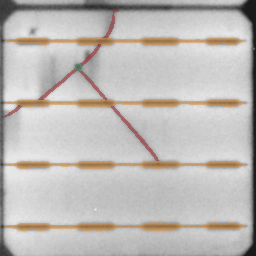

In [168]:
# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)

# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images_val[100], masks_each[100])

In [164]:
# Calcular el IoU para una clase específica
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    if union == 0:
        return float('nan')  # Si no hay ningún píxel verdadero o predicho en esta clase, devolver NaN
    return intersection / union

# Función para calcular Precision
def calculate_precision(pred_mask, true_mask):
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    predicted_positive = pred_mask.sum().item()
    if predicted_positive == 0:
        return float('nan')  # Si no hay ningún píxel predicho positivo, devolver NaN
    return true_positive / predicted_positive

# Función para calcular Recall
def calculate_recall(pred_mask, true_mask):
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    actual_positive = true_mask.sum().item()
    if actual_positive == 0:
        return float('nan')  # Si no hay ningún píxel verdadero positivo, devolver NaN
    return true_positive / actual_positive

# Función para calcular F1 Score
def calculate_f1_score(precision, recall):
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        return float('nan')  # Si alguna de las métricas es NaN o la suma es 0, devolver NaN
    return 2 * (precision * recall) / (precision + recall)

# Función para evaluar las predicciones y calcular todas las métricas
def evaluate_predictions(pred_masks, true_masks):
    ious = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    precisions = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    recalls = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    f1_scores = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        for i, class_name in enumerate(['busbar', 'crack', 'cross', 'dark']):
            iou = calculate_iou(pred_mask[i], true_mask[i])
            precision = calculate_precision(pred_mask[i], true_mask[i])
            recall = calculate_recall(pred_mask[i], true_mask[i])
            f1_score = calculate_f1_score(precision, recall)
            
            ious[class_name].append(iou)
            precisions[class_name].append(precision)
            recalls[class_name].append(recall)
            f1_scores[class_name].append(f1_score)
    
    metrics = {}
    for class_name in ious:
        metrics[class_name] = {
            'IoU': np.nanmean(ious[class_name]),
            'Precision': np.nanmean(precisions[class_name]),
            'Recall': np.nanmean(recalls[class_name]),
            'F1 Score': np.nanmean(f1_scores[class_name])
        }
    return metrics

# Calcular las métricas para las predicciones del modelo.
metrics = evaluate_predictions(masks_each, true_masks)

print("Métricas para las predicciones del modelo:")

for class_name, class_metrics in metrics.items():
    print(f'{class_name}:')
    for metric_name, value in class_metrics.items():
        print(f'  {metric_name}: {value:.4f}')


Métricas para las predicciones del modelo:
busbar:
  IoU: 0.7524
  Precision: 0.8493
  Recall: 0.8688
  F1 Score: 0.8578
crack:
  IoU: 0.5360
  Precision: 0.7024
  Recall: 0.7171
  F1 Score: 0.7303
cross:
  IoU: 0.4398
  Precision: 0.7003
  Recall: 0.5982
  F1 Score: 0.7493
dark:
  IoU: 0.6723
  Precision: 0.7634
  Recall: 0.8687
  F1 Score: 0.8848


In [ ]:

def visualize_comparison(images, predicted_masks, true_masks, index):
	"""
	Visualiza la comparación entre la máscara predicha y la máscara de las anotaciones.
	
	:param images: Lista de imágenes originales.
	:param predicted_masks: Máscaras predichas por el modelo.
	:param true_masks: Máscaras de las anotaciones.
	:param index: Índice de la imagen a visualizar.
	"""
	# Obtener la imagen original, la máscara predicha y la máscara de anotación
	original_img = images[index]
	predicted_mask = predicted_masks[index]
	true_mask = true_masks[index]
	
	# Configurar la figura para la visualización
	fig, axs = plt.subplots(1, 3, figsize=(15, 5))
	
	# Mostrar la imagen original
	axs[0].imshow(cv.cvtColor(original_img, cv.COLOR_BGR2RGB))
	axs[0].set_title('Imagen Original')
	axs[0].axis('off')
	
	# Mostrar la máscara predicha
	predicted_mask_vis = draw_mask(original_img, predicted_mask)
	axs[1].imshow(predicted_mask_vis)
	axs[1].set_title('Máscara Predicha')
	axs[1].axis('off')
	
	# Mostrar la máscara de anotación
	true_mask_vis = draw_mask(original_img, true_mask)
	axs[2].imshow(true_mask_vis)
	axs[2].set_title('Máscara de Anotación')
	axs[2].axis('off')
	
	plt.show()

# Ejemplo de visualización para la primera imagen
visualize_comparison(images_val, masks_each, true_masks, 100)

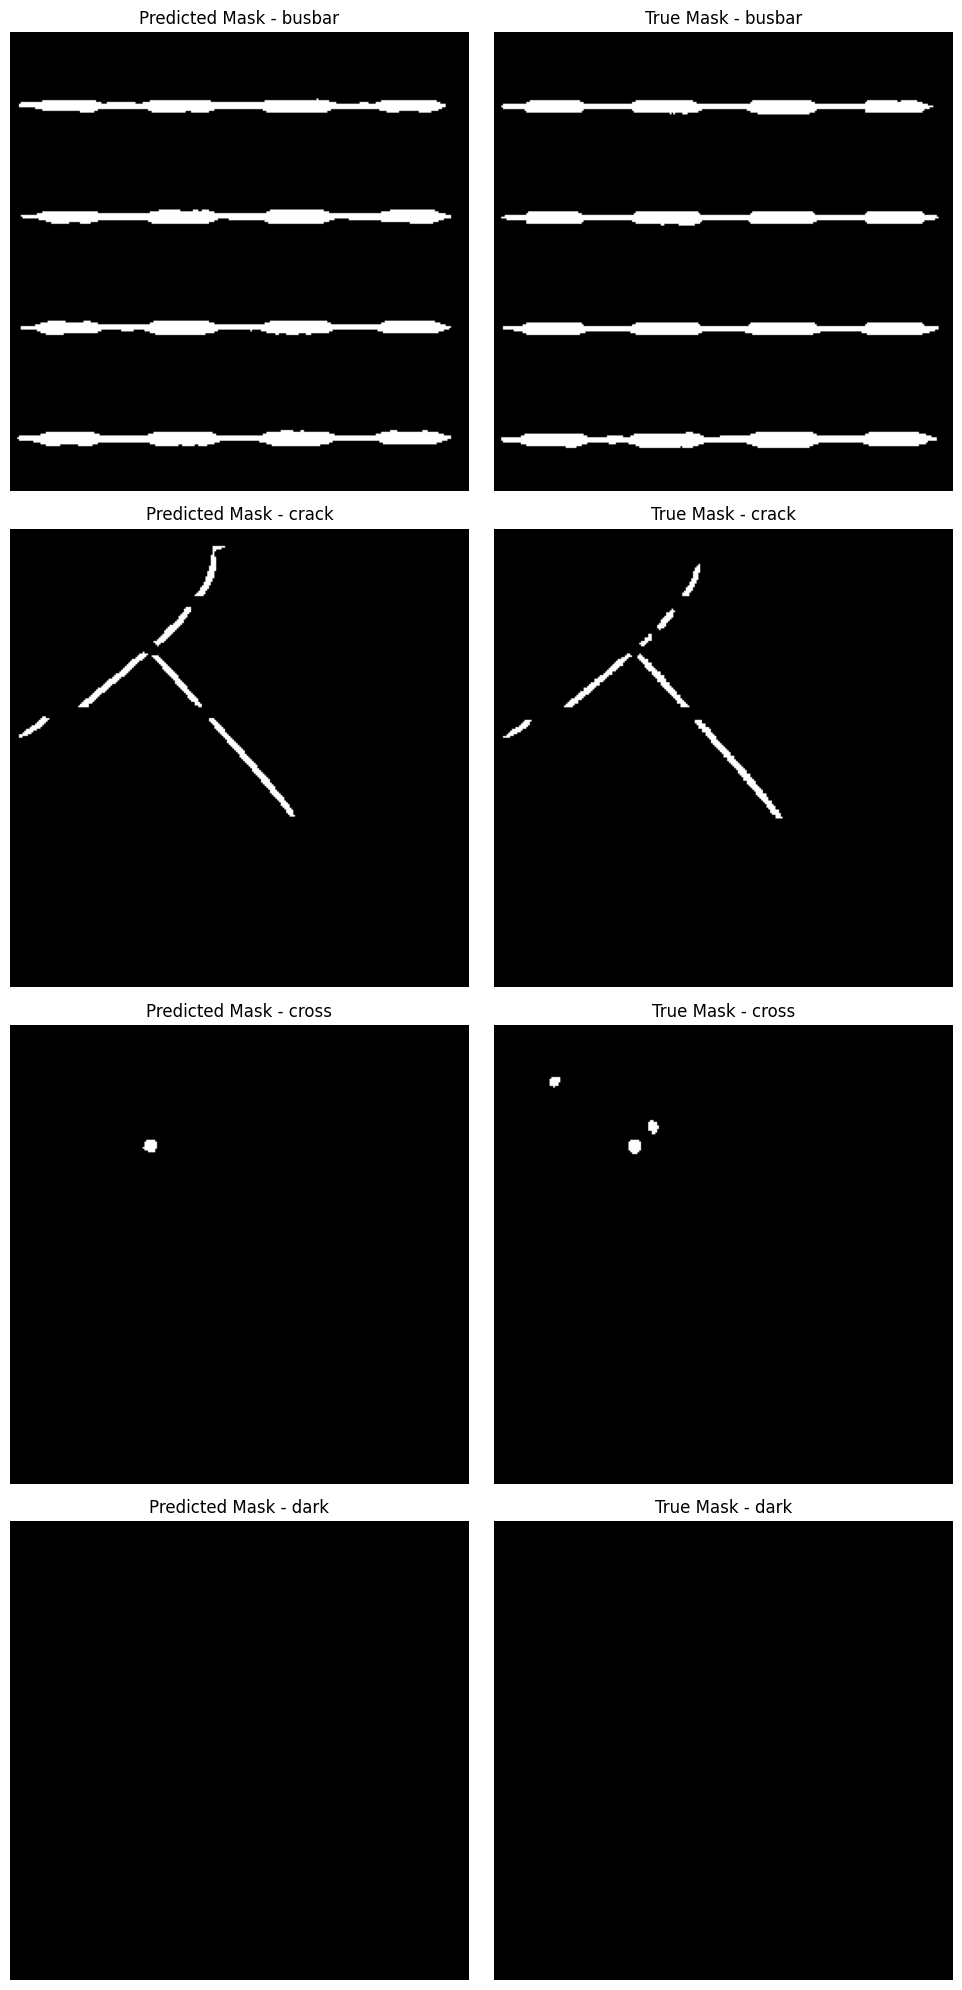

In [166]:

def show_comparison(pred_mask, true_mask, class_names):
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, num_classes * 5))
    
    for i, class_name in enumerate(class_names):
        # Predicted mask for the class
        axes[i, 0].imshow(pred_mask[i], cmap='gray')
        axes[i, 0].set_title(f'Predicted Mask - {class_name}')
        axes[i, 0].axis('off')
        
        # True mask for the class
        axes[i, 1].imshow(true_mask[i], cmap='gray')
        axes[i, 1].set_title(f'True Mask - {class_name}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
# Supongamos que tienes una predicción y una máscara verdadera para comparar:
pred_mask = masks_each[100]  # Primera predicción del modelo
true_mask = true_masks[100]  # Primera máscara de anotación

# Nombres de las clases
class_names = ['busbar', 'crack', 'cross', 'dark']

# Mostrar la comparación
show_comparison(pred_mask, true_mask, class_names)
